1. **Nonlinear System Dynamics**:
   - The `system_dynamics` function represents the nonlinear dynamics of the system. It takes the current state `x` and control input `u` and returns the next state. The nonlinearity comes from the term \( u \cdot (1 - x[0]^2) \), which makes the system's behavior dependent on the square of the current state.

2. **Cost Function**:
   - The `cost_function` defines the objective of the MPC problem. It calculates the cumulative cost over a prediction horizon, considering the states and control inputs. The cost is quadratic, penalizing the square of the states and control input, which is typical for control problems to ensure smooth control actions.

3. **Constraints**:
   - The `constraint` function defines the constraints on the control inputs. In this case, it ensures that the control input `u` is less than 1. This is an inequality constraint, and you can add more constraints as needed for your specific problem.

4. **Optimization Problem**:
   - The `minimize` function from `scipy.optimize` is used to solve the MPC optimization problem. It minimizes the cost function subject to the bounds on the control inputs and the defined constraints. The solution provides the optimal control input sequence `optimal_u` that minimizes the cost over the prediction horizon.

5. **Data Generation**:
   - The `generate_data` function is used to create datasets for training and testing a neural network. It generates random initial states and control input sequences, simulates the system dynamics to create trajectories, and splits the data into training and testing sets based on a predefined ratio.


In [87]:
import numpy as np
import scipy
import copy
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import tensorflow as tf
from tensorflow import keras
from sklearn import datasets

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, DotProduct, WhiteKernel
from sklearn import preprocessing

import tikzplotlib

In [61]:
import numpy as np
from scipy.optimize import minimize

# Define the nonlinear system dynamics
def system_dynamics(x, u):
    # Example of a nonlinear system
    return np.array([x[1], -x[0] + u * (1 - x[0]**2)])

# Define the cost function
def cost_function(u, *args):
    x0, horizon = args
    cost = 0
    x = x0
    for t in range(horizon):
        x = system_dynamics(x, u[t])
        cost += x[0]**2 + x[1]**2 + u[t]**2  # Quadratic cost
    return cost

# Define constraints (if any)
def constraint(u):
    # Example constraint: input must be less than 1
    return 1 - u

# Initial state
x0 = np.array([1, 0])

# Prediction horizon
horizon = 10

# Initial guess for input sequence
u0 = np.zeros(horizon)

# Bounds for the input
bounds = [(-1, 1) for _ in range(horizon)]

# Solve the MPC problem
solution = minimize(cost_function, u0, args=(x0, horizon), bounds=bounds, constraints={'type': 'ineq', 'fun': constraint})

# Extract the optimal input sequence
optimal_u = solution.x

# Generate training and testing data
def generate_data(samples, horizon):
    training_data = []
    testing_data = []
    for _ in range(samples):
        initial_state = np.random.rand(2) * 2 - 1  # Random initial state
        u_sequence = np.random.rand(horizon) * 2 - 1  # Random input sequence
        trajectory = [initial_state]
        for u in u_sequence:
            trajectory.append(system_dynamics(trajectory[-1], u))
        if np.random.rand() > 0.8:  # 20% for testing, 80% for training
            testing_data.append((initial_state, u_sequence, trajectory))
        else:
            training_data.append((initial_state, u_sequence, trajectory))
    return training_data, testing_data


# Example usage
training_data, testing_data = generate_data(1000, horizon)



In [74]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input

# Load your training data (training_data) and testing data (testing_data)

# Extract features from the data
def extract_features(data):
    initial_states, input_sequences, _ = zip(*data)
    return np.concatenate((initial_states, input_sequences), axis=1)

# Prepare training and testing features
X_train = extract_features(training_data)
X_test = extract_features(testing_data)

# Prepare target labels (next state)
def extract_targets(data):
    _, _, trajectories = zip(*data)
    return np.array([traj[-1] for traj in trajectories])

y_train = extract_targets(training_data)
y_test = extract_targets(testing_data)

# Create a simple feedforward neural network
model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dense(128, activation='relu'),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(2)  # Output layer with 2 units (for x and y coordinates)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=16, validation_data=(X_test, y_test))

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print(f"Test loss: {loss:.4f}")



Epoch 1/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.2010 - val_loss: 0.4722
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4926 - val_loss: 0.4663
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4530 - val_loss: 0.3860
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3676 - val_loss: 0.3507
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3080 - val_loss: 0.3401
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3019 - val_loss: 0.3260
Epoch 7/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2233 - val_loss: 0.3553
Epoch 8/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2737 - val_loss: 0.3206
Epoch 9/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1679 - val_loss: 0.4247
Epoch 10/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1620 - val_loss: 0.3255
Epoch 11/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1103 - val_loss: 0.3326
Epoch 12/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


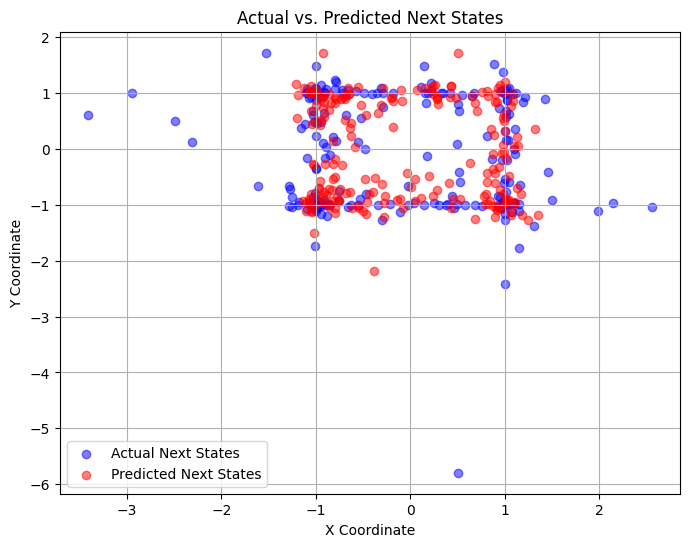

In [75]:
import matplotlib.pyplot as plt

# Predict next states using the trained model
y_pred = model.predict(X_test)

# Plot the x and y coordinates
plt.figure(figsize=(8, 6))
plt.scatter(y_test[:, 0], y_test[:, 1], label="Actual Next States", color='b', alpha=0.5)
plt.scatter(y_pred[:, 0], y_pred[:, 1], label="Predicted Next States", color='r', alpha=0.5)
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.title("Actual vs. Predicted Next States")
plt.legend()
plt.grid(True)
plt.show()


In [276]:
print("X_test, X_train shape:", X_test.shape)
print("y_test, y_train shape:", y_test.shape)

X_test, X_train shape: (208, 12)
y_test, y_train shape: (208, 2)


In [187]:
import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample
import torch.nn as nn


class MyFirstBNN(PyroModule):
    def __init__(self, in_dim=1, out_dim=1, hid_dim=5, prior_scale=10.):
        super().__init__()

        self.activation = nn.Tanh()  # or nn.ReLU()
        self.layer1 = PyroModule[nn.Linear](in_dim, hid_dim)  # Input to hidden layer
        self.layer2 = PyroModule[nn.Linear](hid_dim, out_dim)  # Hidden to output layer

        # Set layer parameters as random variables
        self.layer1.weight = PyroSample(dist.Normal(0., prior_scale).expand([hid_dim, in_dim]).to_event(2))
        self.layer1.bias = PyroSample(dist.Normal(0., prior_scale).expand([hid_dim]).to_event(1))
        self.layer2.weight = PyroSample(dist.Normal(0., prior_scale).expand([out_dim, hid_dim]).to_event(2))
        self.layer2.bias = PyroSample(dist.Normal(0., prior_scale).expand([out_dim]).to_event(1))

    def forward(self, x, y=None):
        x = x.reshape(-1, 1)
        x = self.activation(self.layer1(x))
        mu = self.layer2(x).squeeze()
        sigma = pyro.sample("sigma", dist.Gamma(.5, 1))  # Infer the response noise

        # Sampling model
        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Normal(mu, sigma * sigma), obs=y)
        return mu

In [277]:
import torch

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

In [194]:
from pyro.infer import MCMC, NUTS

model = MyFirstBNN()

# Set Pyro random seed
pyro.set_rng_seed(42)

# Define Hamiltonian Monte Carlo (HMC) kernel
# NUTS = "No-U-Turn Sampler" (https://arxiv.org/abs/1111.4246), gives HMC an adaptive step size
nuts_kernel = NUTS(model, jit_compile=True)  # jit_compile=True is faster but requires PyTorch 1.6+

# Define MCMC sampler, get 50 posterior samples
mcmc.run(X_train_tensor, y_train_tensor)


Sample: 100%|██████████| 100/100 [02:08,  1.28s/it, step size=1.05e-03, acc. prob=0.945]


In [234]:
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

In [235]:
from pyro.infer import Predictive

# Create a Predictive object with return_sites=("obs",)
predictive = Predictive(model=model, posterior_samples=mcmc.get_samples(), return_sites=("obs",))

# Generate predictions
preds = predictive(X_test_tensor)

# Extract mean and standard deviation from the predictions
preds_mean = preds["obs"].mean(axis=0).detach().numpy()
preds_std = preds["obs"].std(axis=0).detach().numpy()


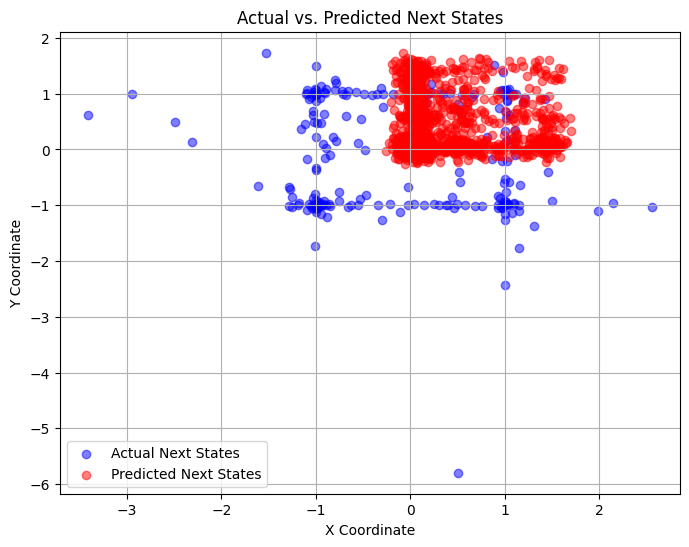

In [213]:
import matplotlib.pyplot as plt

# Get mean predictions
y_pred_mean = preds["obs"].mean(axis=0).detach().numpy()
y_pred_mean = y_pred_mean.reshape(-1, 2)

# Plot actual vs predicted next states
plt.figure(figsize=(8, 6))
plt.scatter(y_test[:, 0], y_test[:, 1], label="Actual Next States", color='b', alpha=0.5)
plt.scatter(y_pred_mean[:, 0], y_pred_mean[:, 1], label="Predicted Next States", color='r', alpha=0.5)
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.title("Actual vs. Predicted Next States")
plt.legend()
plt.grid(True)
plt.show()


/home/johannes/standard/lib/python3.11/site-packages/seaborn/distributions.py:1176: UserWarning: linewidths is ignored by contourf
  cset = contour_func(


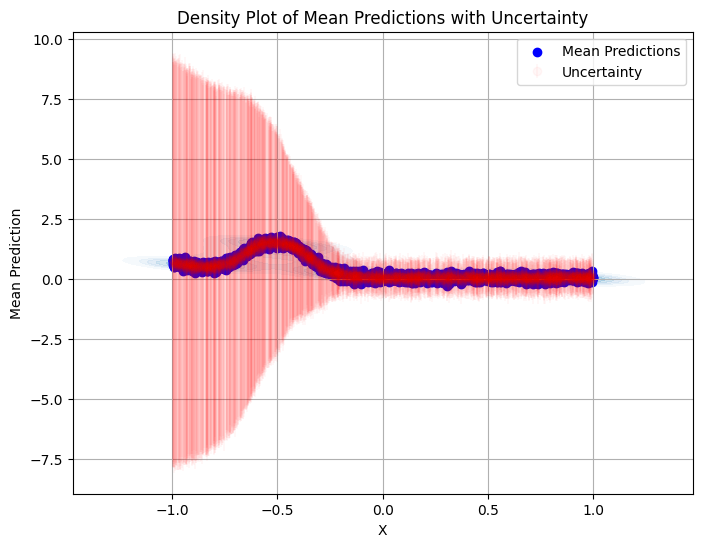

In [241]:
import seaborn as sns
import pandas as pd

# Combine mean predictions and uncertainty into a DataFrame
df = pd.DataFrame({'X': X_test_tensor.numpy().flatten(), 'Mean Prediction': preds_mean.flatten(), 'Uncertainty': preds_std.flatten()})

plt.figure(figsize=(8, 6))
sns.kdeplot(data=df, x='X', y='Mean Prediction', fill=True, levels=10, cmap='Blues', thresh=0.05, alpha=0.5, linewidths=0)
plt.scatter(df['X'], df['Mean Prediction'], c='b', label="Mean Predictions")
plt.errorbar(df['X'], df['Mean Prediction'], yerr=df['Uncertainty'], fmt='o', color='r', alpha=0.03, label="Uncertainty")  # Adjust alpha here
plt.xlabel("X")
plt.ylabel("Mean Prediction")
plt.title("Density Plot of Mean Predictions with Uncertainty")
plt.legend()
plt.grid(True)
plt.show()



In [242]:
class BNN(PyroModule):
    def __init__(self, in_dim=1, out_dim=1, hid_dim=10, n_hid_layers=5, prior_scale=5.):
        super().__init__()

        self.activation = nn.Tanh()  # could also be ReLU or LeakyReLU
        assert in_dim > 0 and out_dim > 0 and hid_dim > 0 and n_hid_layers > 0  # make sure the dimensions are valid

        # Define the layer sizes and the PyroModule layer list
        self.layer_sizes = [in_dim] + n_hid_layers * [hid_dim] + [out_dim]
        layer_list = [PyroModule[nn.Linear](self.layer_sizes[idx - 1], self.layer_sizes[idx]) for idx in
                      range(1, len(self.layer_sizes))]
        self.layers = PyroModule[torch.nn.ModuleList](layer_list)

        for layer_idx, layer in enumerate(self.layers):
            layer.weight = PyroSample(dist.Normal(0., prior_scale * np.sqrt(2 / self.layer_sizes[layer_idx])).expand(
                [self.layer_sizes[layer_idx + 1], self.layer_sizes[layer_idx]]).to_event(2))
            layer.bias = PyroSample(dist.Normal(0., prior_scale).expand([self.layer_sizes[layer_idx + 1]]).to_event(1))

    def forward(self, x, y=None):
        x = x.reshape(-1, 1)
        x = self.activation(self.layers[0](x))  # input --> hidden
        for layer in self.layers[1:-1]:
            x = self.activation(layer(x))  # hidden --> hidden
        mu = self.layers[-1](x).squeeze()  # hidden --> output
        sigma = pyro.sample("sigma", dist.Gamma(.5, 1))  # infer the response noise

        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Normal(mu, sigma * sigma), obs=y)
        return mu



In [247]:
# define model and data
model2 = BNN(hid_dim=50, n_hid_layers=10, prior_scale=5.)

# define MCMC sampler
nuts_kernel = NUTS(model2, jit_compile=True)
mcmc = MCMC(nuts_kernel, num_samples=50)
mcmc.run(X_train_tensor, y_train_tensor)

Warmup:   0%|          | 0/100 [00:00, ?it/s]

/home/johannes/standard/lib/python3.11/site-packages/pyro/poutine/subsample_messenger.py:70: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  result = torch.tensor(0.0, device=self.device)
Sample: 100%|██████████| 100/100 [11:32,  6.93s/it, step size=1.49e-04, acc. prob=0.596]


In [250]:
from pyro.infer import Predictive

# Create a Predictive object with return_sites=("obs",)
predictive = Predictive(model=model2, posterior_samples=mcmc.get_samples(), return_sites=("obs",))

# Generate predictions
preds = predictive(X_test_tensor)

# Extract mean and standard deviation from the predictions
preds_mean = preds["obs"].mean(axis=0).detach().numpy()
preds_std = preds["obs"].std(axis=0).detach().numpy()


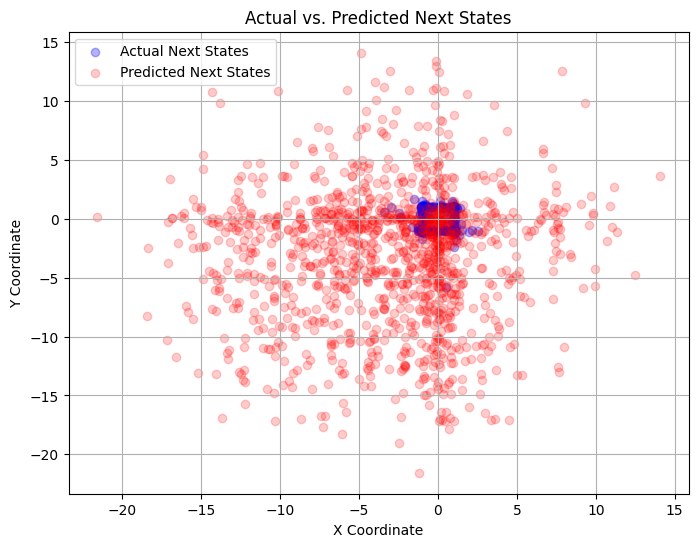

In [262]:
import matplotlib.pyplot as plt

# Get mean predictions
y_pred_mean = preds["obs"].mean(axis=0).detach().numpy()
y_pred_mean = y_pred_mean.reshape(-1, 2)

# Plot actual vs predicted next states
plt.figure(figsize=(8, 6))
plt.scatter(y_test[:, 0], y_test[:, 1], label="Actual Next States", color='b', alpha=0.3)
plt.scatter(y_pred_mean[:, 0], y_pred_mean[:, 1], label="Predicted Next States", color='r', alpha=0.2)
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.title("Actual vs. Predicted Next States")
plt.legend()
plt.grid(True)
plt.show()


/home/johannes/standard/lib/python3.11/site-packages/seaborn/distributions.py:1176: UserWarning: linewidths is ignored by contourf
  cset = contour_func(


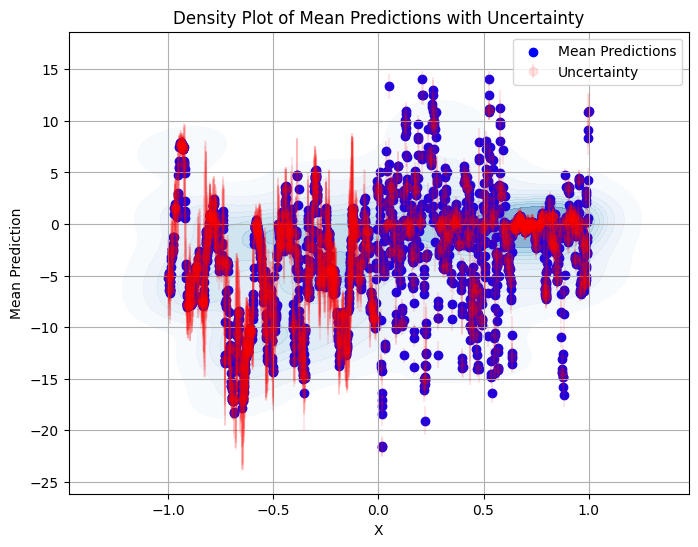

In [255]:
import seaborn as sns
import pandas as pd

# Combine mean predictions and uncertainty into a DataFrame
df = pd.DataFrame({'X': X_test_tensor.numpy().flatten(), 'Mean Prediction': preds_mean.flatten(), 'Uncertainty': preds_std.flatten()})

plt.figure(figsize=(8, 6))
sns.kdeplot(data=df, x='X', y='Mean Prediction', fill=True, levels=10, cmap='Blues', thresh=0.05, alpha=0.5, linewidths=0)
plt.scatter(df['X'], df['Mean Prediction'], c='b', label="Mean Predictions")
plt.errorbar(df['X'], df['Mean Prediction'], yerr=df['Uncertainty'], fmt='o', color='r', alpha=0.1, label="Uncertainty")  # Adjust alpha here
plt.xlabel("X")
plt.ylabel("Mean Prediction")
plt.title("Density Plot of Mean Predictions with Uncertainty")
plt.legend()
plt.grid(True)
plt.show()



In [267]:
class BNN(PyroModule):
    def __init__(self, in_dim=1, out_dim=1, hid_dim=10, n_hid_layers=5, prior_scale=5.):
        super().__init__()

        self.activation = nn.Tanh()  # could also be ReLU or LeakyReLU
        assert in_dim > 0 and out_dim > 0 and hid_dim > 0 and n_hid_layers > 0  # make sure the dimensions are valid

        # Define the layer sizes and the PyroModule layer list
        self.layer_sizes = [in_dim] + n_hid_layers * [hid_dim] + [out_dim]
        layer_list = [PyroModule[nn.Linear](self.layer_sizes[idx - 1], self.layer_sizes[idx]) for idx in
                      range(1, len(self.layer_sizes))]
        self.layers = PyroModule[torch.nn.ModuleList](layer_list)
        self.batch_norm2 = nn.BatchNorm1d(hid_dim)
        self.dropout2 = nn.Dropout(p=0.5)

        for layer_idx, layer in enumerate(self.layers):
            layer.weight = PyroSample(dist.Normal(0., prior_scale * np.sqrt(2 / self.layer_sizes[layer_idx])).expand(
                [self.layer_sizes[layer_idx + 1], self.layer_sizes[layer_idx]]).to_event(2))
            layer.bias = PyroSample(dist.Normal(0., prior_scale).expand([self.layer_sizes[layer_idx + 1]]).to_event(1))

    def forward(self, x, y=None):
        x = x.reshape(-1, 1)
        x = self.activation(self.layers[0](x))  # input --> hidden
        for layer in self.layers[1:-1]:
            x = self.activation(layer(x))  # hidden --> hidden
        mu = self.layers[-1](x).squeeze()  # hidden --> output
        sigma = pyro.sample("sigma", dist.Gamma(.5, 1))  # infer the response noise

        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Normal(mu, sigma * sigma), obs=y)
        return mu


        
        


In [268]:
# define model and data
model3 = BNN(hid_dim=5, n_hid_layers=10, prior_scale=5.)

# define MCMC sampler
nuts_kernel = NUTS(model3, jit_compile=True)
mcmc = MCMC(nuts_kernel, num_samples=50)
mcmc.run(X_train_tensor, y_train_tensor)

Warmup:   0%|          | 0/100 [00:00, ?it/s]/home/johannes/standard/lib/python3.11/site-packages/pyro/poutine/subsample_messenger.py:70: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  result = torch.tensor(0.0, device=self.device)
Sample: 100%|██████████| 100/100 [02:26,  1.47s/it, step size=3.05e-03, acc. prob=0.644]


In [269]:
from pyro.infer import Predictive

# Create a Predictive object with return_sites=("obs",)
predictive = Predictive(model=model3, posterior_samples=mcmc.get_samples(), return_sites=("obs",))

# Generate predictions
preds = predictive(X_test_tensor)

# Extract mean and standard deviation from the predictions
preds_mean = preds["obs"].mean(axis=0).detach().numpy()
preds_std = preds["obs"].std(axis=0).detach().numpy()


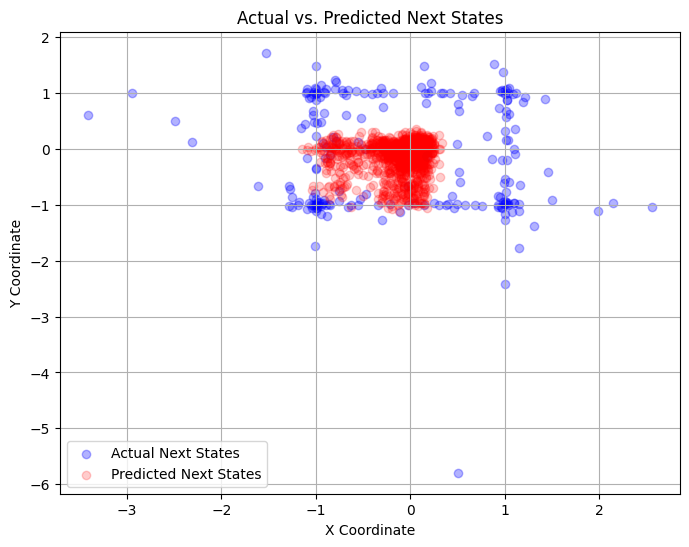

In [270]:
import matplotlib.pyplot as plt

# Get mean predictions
y_pred_mean = preds["obs"].mean(axis=0).detach().numpy()
y_pred_mean = y_pred_mean.reshape(-1, 2)

# Plot actual vs predicted next states
plt.figure(figsize=(8, 6))
plt.scatter(y_test[:, 0], y_test[:, 1], label="Actual Next States", color='b', alpha=0.3)
plt.scatter(y_pred_mean[:, 0], y_pred_mean[:, 1], label="Predicted Next States", color='r', alpha=0.2)
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.title("Actual vs. Predicted Next States")
plt.legend()
plt.grid(True)
plt.show()


/home/johannes/standard/lib/python3.11/site-packages/seaborn/distributions.py:1176: UserWarning: linewidths is ignored by contourf
  cset = contour_func(


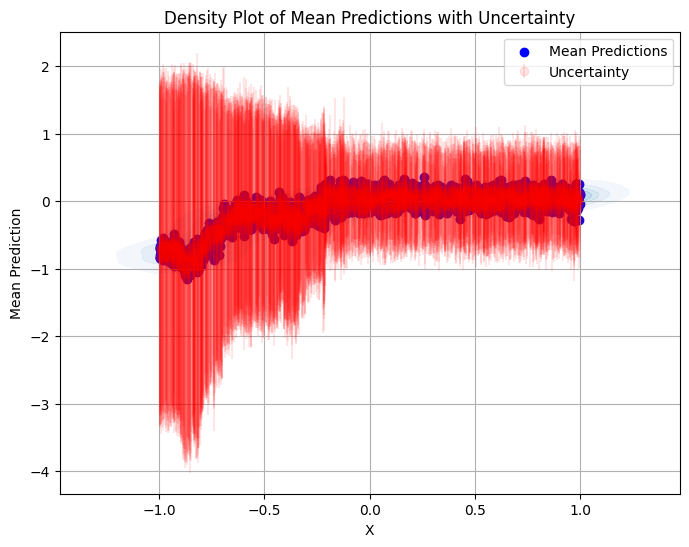

In [271]:
import seaborn as sns
import pandas as pd

# Combine mean predictions and uncertainty into a DataFrame
df = pd.DataFrame({'X': X_test_tensor.numpy().flatten(), 'Mean Prediction': preds_mean.flatten(), 'Uncertainty': preds_std.flatten()})

plt.figure(figsize=(8, 6))
sns.kdeplot(data=df, x='X', y='Mean Prediction', fill=True, levels=10, cmap='Blues', thresh=0.05, alpha=0.5, linewidths=0)
plt.scatter(df['X'], df['Mean Prediction'], c='b', label="Mean Predictions")
plt.errorbar(df['X'], df['Mean Prediction'], yerr=df['Uncertainty'], fmt='o', color='r', alpha=0.1, label="Uncertainty")  # Adjust alpha here
plt.xlabel("X")
plt.ylabel("Mean Prediction")
plt.title("Density Plot of Mean Predictions with Uncertainty")
plt.legend()
plt.grid(True)
plt.show()



In [286]:
class MyBNNWithBayesianLastLayer(PyroModule):
    def __init__(self, in_dim=1, out_dim=1, hid_dim=5, prior_scale=10.):
        super().__init__()

        self.activation = nn.Tanh()  # or nn.ReLU()

        # Define the layers except for the last one
        self.layer1 = nn.Linear(in_dim, hid_dim)
        self.layer2 = nn.Linear(hid_dim, hid_dim)
        
        # Bayesian last layer
        self.bayesian_layer = PyroModule[nn.Linear](hid_dim, out_dim)
        self.batch_norm2 = nn.BatchNorm1d(hid_dim)
        self.dropout2 = nn.Dropout(p=0.5)

        # Initialize the last layer's weights and biases as PyroSamples
        self.bayesian_layer.weight = PyroSample(dist.Normal(0., prior_scale).expand([out_dim, hid_dim]).to_event(2))
        self.bayesian_layer.bias = PyroSample(dist.Normal(0., prior_scale).expand([out_dim]).to_event(1))

    def forward(self, x, y=None):
        x = x.reshape(-1, 1)
        x = self.activation(self.layer1(x))  # input --> hidden
        x = self.activation(self.layer2(x))  # hidden --> hidden
        x = self.activation(self.batch_norm2(x))  # last hidden layer
        x = self.dropout2(x)  # last hidden layer with dropout
        mu = self.bayesian_layer(x).squeeze()  # hidden --> output
        sigma = pyro.sample("sigma", dist.Gamma(.5, 1))  # infer the response noise

        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Normal(mu, sigma * sigma), obs=y)
        return mu


In [287]:
# define model and data
bnn_model = MyBNNWithBayesianLastLayer(in_dim=12, out_dim=2, hid_dim=10, prior_scale=5.)


# define MCMC sampler
nuts_kernel = NUTS(model3, jit_compile=True)
mcmc = MCMC(nuts_kernel, num_samples=50)
mcmc.run(X_train_tensor, y_train_tensor)

Warmup:   0%|          | 0/100 [00:00, ?it/s]

RuntimeError: mat1 and mat2 shapes cannot be multiplied (100x1 and 12x20)
     Trace Shapes:      
      Param Sites:      
 layers$$$0.weight 20 12
   layers$$$0.bias    20
 layers$$$1.weight 20 20
   layers$$$1.bias    20
 layers$$$2.weight 20 20
   layers$$$2.bias    20
 layers$$$3.weight 20 20
   layers$$$3.bias    20
 layers$$$4.weight 20 20
   layers$$$4.bias    20
 layers$$$5.weight 20 20
   layers$$$5.bias    20
 layers$$$6.weight 20 20
   layers$$$6.bias    20
 layers$$$7.weight 20 20
   layers$$$7.bias    20
 layers$$$8.weight 20 20
   layers$$$8.bias    20
 layers$$$9.weight 20 20
   layers$$$9.bias    20
layers$$$10.weight  2 20
  layers$$$10.bias     2
     Sample Sites:      